# versione corretta e runnata su colab

In [3]:
!pip install torchmetrics
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.5 MB/s eta 0:00:00


In [4]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F

In [5]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-04 17:46:42--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-04 17:46:43--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  12.4MB/s    in 5m 23s  

2025-01-04 17:52:06 (11.9 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-04 17:52:06--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request 

In [6]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


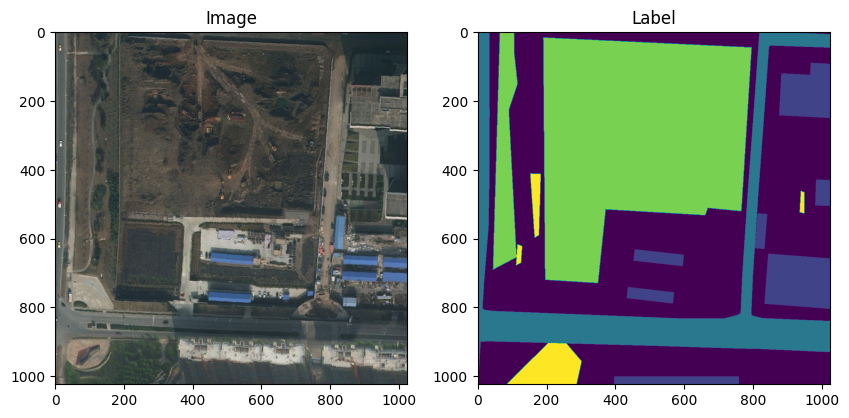

In [7]:

# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()


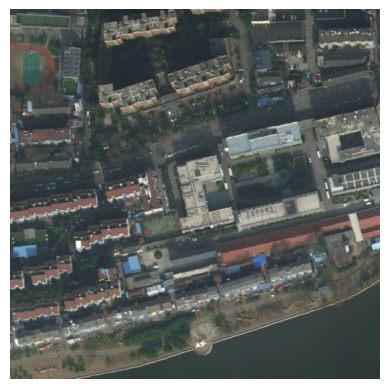

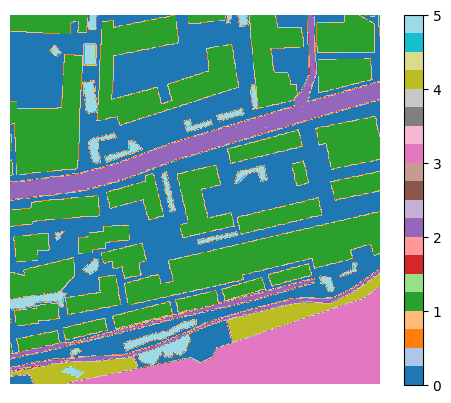

In [20]:
#TASK 3.a

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()



class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural"):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label

        # Image and Label paths
        self.image_paths = []
        self.label_paths = []


        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):  # Assuming the files are PNG images
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.transform_image:
            image = self.transform_image(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

# Define transformations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Create dataset and dataloader
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 100  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]
# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# Crea un DataLoader per il subset
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True)
# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break





In [21]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd PIDNet

fatal: destination path 'PIDNet' already exists and is not an empty directory.
/content/PIDNet


In [22]:
from models.pidnet import get_pred_model

# Initialize PIDNet-S model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_pred_model(name='pidnet_s', num_classes=7).to(device)


In [23]:
%cd ..

/content


In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class segmentation loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.

# Training loop
num_epochs = 20
best_miou = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader: #train_loader
        images, masks = images.to('cuda'), masks.to('cuda')

        masks = masks.argmax(dim=1)  # Convert to class indices

        # Forward pass
        outputs = model(images)  # Shape: [batch_size, num_classes, 64, 64]

        # Resize outputs to match the size of masks (512x512)
        outputs_resized = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

        # Compute the loss
        loss = criterion(outputs_resized, masks)  # Now the sizes match

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)#len(train_subset_loader)# len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Training Loss: {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to('cuda'), masks.to('cuda')

            # Forward pass
            outputs = model(images)  # [batch_size, num_classes, 64, 64]
            preds = torch.argmax(outputs, dim=1)  # [batch_size, 64, 64]

            # Convert masks to class indices format if one-hot encoded
            if masks.ndim == 4:  # [batch_size, num_classes, height, width]
                masks = masks.argmax(dim=1)  # [batch_size, height, width]

            # Resize preds to match the size of the masks
            preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

            # Calculate per-class IoU
            for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
                true_class = (masks == class_name)
                pred_class = (preds_resized == class_name)

                intersection = torch.sum(true_class & pred_class).float()
                union = torch.sum(true_class | pred_class).float()

                if union != 0:
                    val_class_iou[class_name] += intersection / union
                val_class_counts[class_name] += 1

            # Calculate overall mIoU for this batch
            val_miou += jaccard(preds_resized, masks)

    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), avg_class_iou.tolist()))}")

    # Save the best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")

Epoch [1/20] - Average Training Loss: 1.3638
Epoch [1/20] - Validation mIoU: 0.0542
Epoch [1/20] - Per-Class IoU: {'Background': 0.29718855023384094, 'Building': 0.066095270216465, 'Road': 0.012197832576930523, 'Water': 0.0, 'Barren': 0.0, 'Forest': 0.0001581078686285764, 'Agricultural': 0.0}
Epoch [2/20] - Average Training Loss: 1.2623
Epoch [2/20] - Validation mIoU: 0.0655
Epoch [2/20] - Per-Class IoU: {'Background': 0.3365668058395386, 'Building': 0.09249304234981537, 'Road': 0.024493353441357613, 'Water': 0.0, 'Barren': 0.0, 'Forest': 0.0, 'Agricultural': 0.0}
Epoch [3/20] - Average Training Loss: 1.2080
Epoch [3/20] - Validation mIoU: 0.0862
Epoch [3/20] - Per-Class IoU: {'Background': 0.37991008162498474, 'Building': 0.1250474452972412, 'Road': 0.017535435035824776, 'Water': 0.003154630307108164, 'Barren': 0.00029864994576200843, 'Forest': 0.07108498364686966, 'Agricultural': 6.211686240931158e-07}
Epoch [4/20] - Average Training Loss: 1.1724
Epoch [4/20] - Validation mIoU: 0.091